In [1]:
import numpy as np
import matplotlib.pyplot as plt

Read in an image of a domino with plt.imread()

In [2]:
im_c = plt.imread("test set 1/bottom_a49.jpg")

Show that it has successfully read.

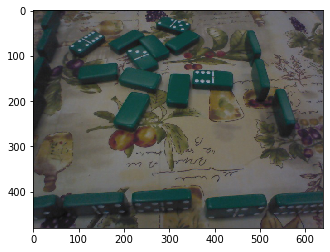

In [3]:
plt.imshow(im_c)

Convert the image to grayscale and create histogram.

<BarContainer object of 100 artists>

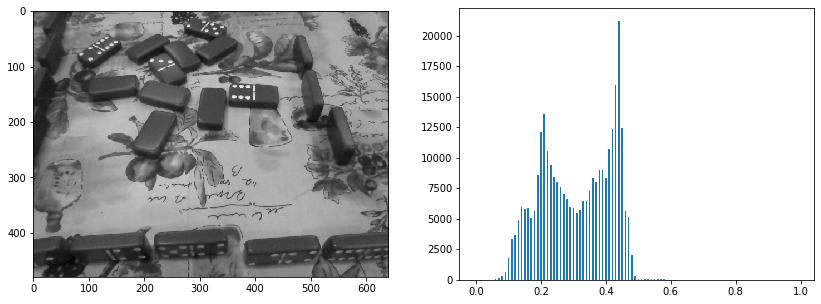

In [4]:
from skimage import color

im_g = color.rgb2gray(im_c)

hist, bins = np.histogram(im_g,bins=np.linspace(0,1,101))

fig, ax = plt.subplots(ncols=2,figsize=(14,5))

ax[0].imshow(im_g, cmap='gray')
ax[1].bar(bins[:-1],hist,width=0.005)

This histogram shows me that there are barely any high intensity pixels. I might want to fix that with equalize_hist.

<BarContainer object of 100 artists>

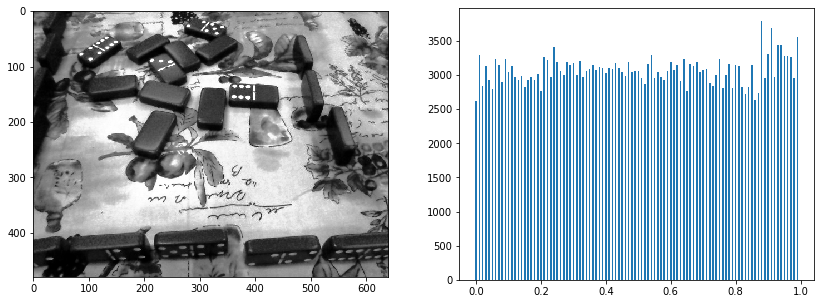

In [5]:
from skimage import exposure

im_eq = exposure.equalize_hist(im_g)

hist, bins = np.histogram(im_eq,bins=np.linspace(0,1,101))

fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(im_eq, cmap='gray')
ax[1].bar(bins[:-1],hist,width=0.005)

I'll test if this image is easier to detect afterwards.

Test background subtraction from L4.

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


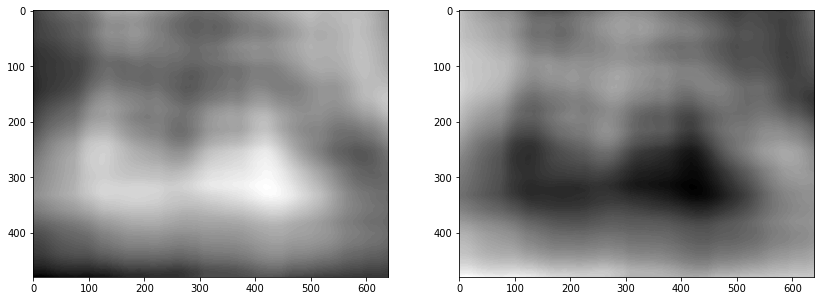

In [6]:
import skimage.filters as flt
from skimage.morphology import square

def custom_uint(im):
    
    imin = np.min(im)
    imax = np.max(im)
    full = imax - imin
    new = np.round(255*(im - imin)/full, 0)
    return new.astype(int)

im_bg = flt.rank.mean(im_g,square(150))
im_sub = custom_uint(im_g-1*im_bg)

fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(im_bg, cmap='gray')
ax[1].imshow(im_sub, cmap='gray')

This didn't help at all.

Try edge detection from the feature module.

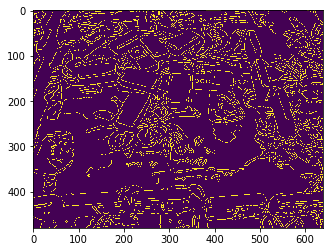

In [7]:
from skimage.feature import canny

edges = canny(im_eq,sigma=1.5)
plt.imshow(edges)

Only 4 dots were correctly detected and most of the background as well.

Try a different filter.

In [8]:
thresh = flt.threshold_otsu(im_eq)
thresh

0.5019596099853516

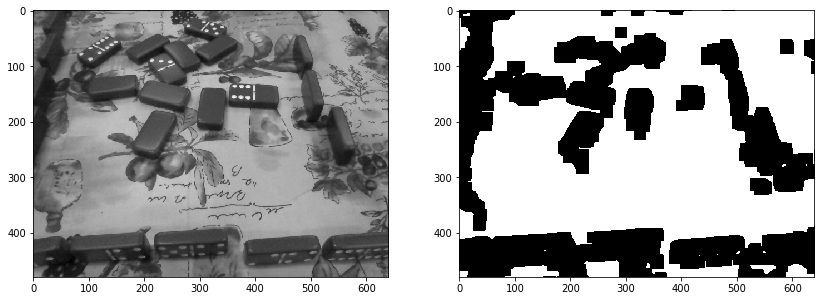

In [9]:
from skimage.morphology import closing

bw = closing(im_eq>thresh, square(20))
bw
fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(im_g, cmap='gray')
ax[1].imshow(bw, cmap='gray')

Might be able to detect dominoes with this.

I'm thinking the dots are too small compared to the larger objects.

Let's try template matching.

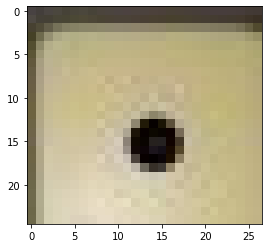

In [10]:
dot = plt.imread("template matching/singledot.jpg")
plt.imshow(dot)

In [11]:
dot.shape

(25, 27, 3)

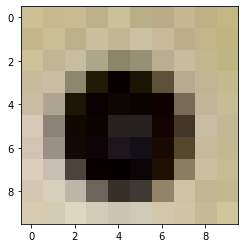

In [12]:
just_the_dot = dot[10:20,10:20]
plt.imshow(just_the_dot)

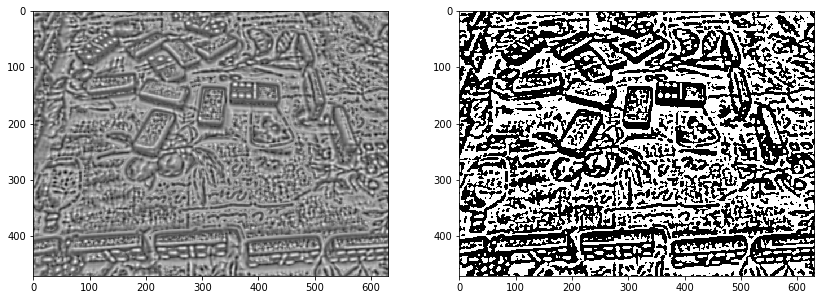

In [55]:
from skimage.feature import match_template

dot = color.rgb2gray(just_the_dot)

result1 = 1-match_template(im_g,dot)
result_b = result1> flt.threshold_otsu(result1)

fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(result1, cmap='gray')
ax[1].imshow(result_b, cmap='gray')

In [58]:
im_g.shape

(480, 640)

How about subtracting the background we got from the otsu_threshold and then template match?

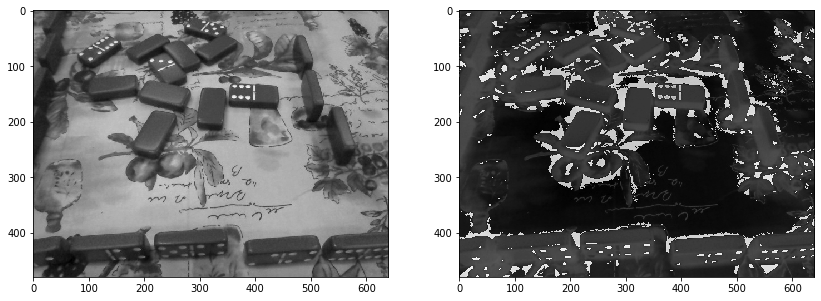

In [19]:
thresh_l = flt.threshold_local(im_g,61,offset=-0.06)
local = im_g>thresh_l
im_local = local-im_g

fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(im_g, cmap='gray')
ax[1].imshow(im_local, cmap='gray')

Now try template matching.

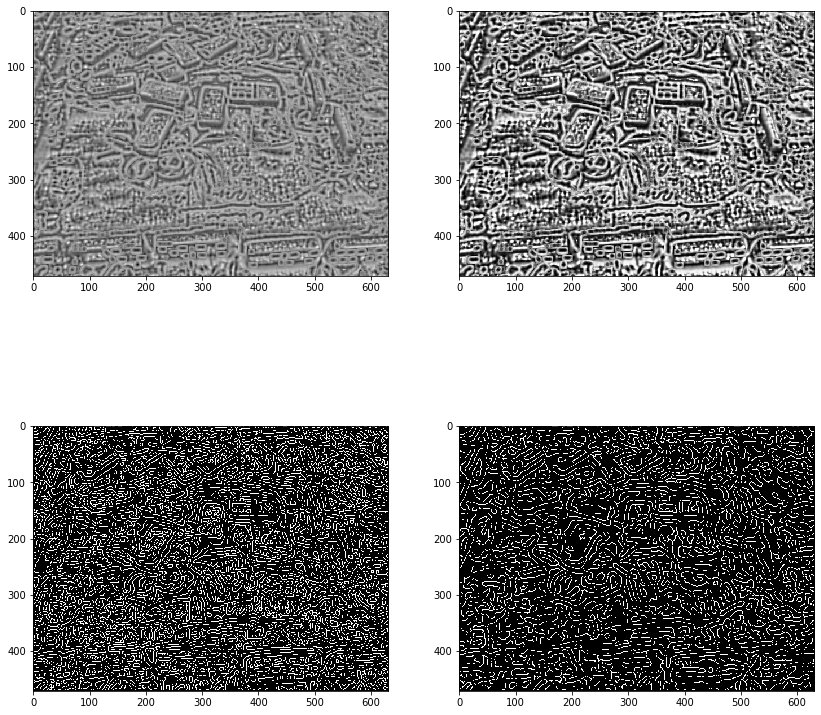

In [43]:
result = match_template(im_local,dot)
#thresh = flt.threshold_otsu(result)

#dots_1 = result>thresh
result_eq = exposure.equalize_hist(result)
result_edge = canny(result,sigma=2.0)
result_eq_edge = canny(result_eq,sigma=3.5)

fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(14,14))
ax[0,0].imshow(result, cmap='gray')
ax[0,1].imshow(result_eq, cmap='gray')

ax[1,0].imshow(result_edge, cmap='gray')
ax[1,1].imshow(result_eq_edge, cmap='gray')

Harini suggests using the measure module.

In [60]:
from skimage.measure import find_contours
from skimage.transform import resize

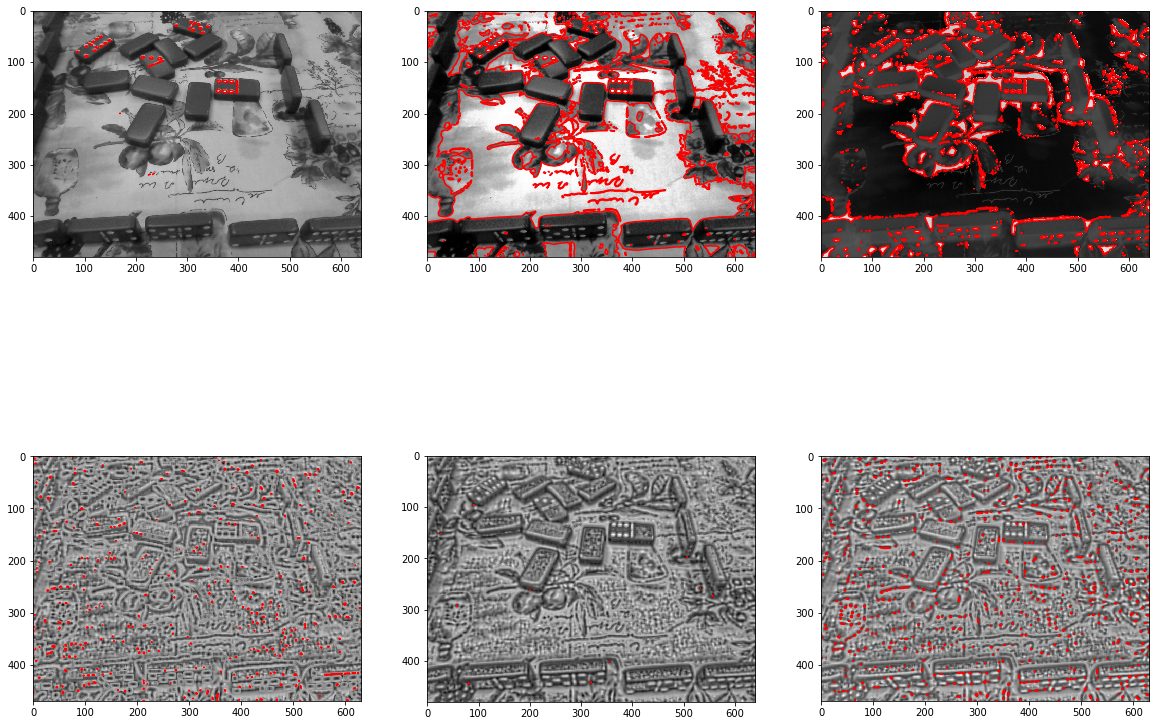

In [66]:

fig,ax = plt.subplots(nrows=2, ncols=3,figsize=(20,15))

test1 = im_g+resize(result1,(im_g.shape[0],im_g.shape[1]))

ax[0,0].imshow(im_g,cmap='gray')
ax[0,1].imshow(im_eq,cmap='gray')
ax[0,2].imshow(im_local,cmap='gray')
ax[1,0].imshow(result,cmap='gray')
ax[1,1].imshow(test1,cmap='gray')
ax[1,2].imshow(result1,cmap='gray')

contours = [find_contours(im_g,0.5),find_contours(im_eq,0.5),find_contours(im_local,0.45),
            find_contours(result,0.5),find_contours(test1,0.5),find_contours(result1,0.5)]

for col,im in enumerate(contours):
    if col<3:
        row=0
    else:
        row=1
    for n, contour in enumerate(im):
        if col>2:
            col=abs(3-col)
        else:
            pass
        ax[row,col].plot(contour[:,1],contour[:,0],color='r')

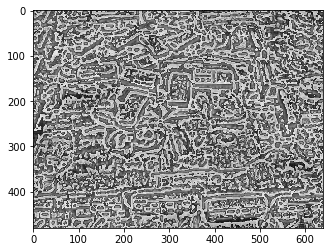

In [71]:

thresh_l = flt.threshold_local(result,61,offset=-0.06)
local = resize(result>thresh_l , (im_g.shape[0],im_g.shape[1]))
result_local = local-resize(result ,(im_g.shape[0],im_g.shape[1]))

plt.imshow(result_local,cmap='gray')

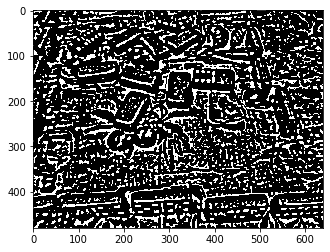

In [76]:
thresh = flt.threshold_local(test1,61,offset=-0.2)
test1_thresh = test1>thresh
plt.imshow(test1_thresh,cmap='gray')

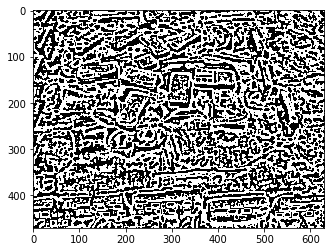

In [79]:
thresh = flt.threshold_local(result,69,offset=-0.02)
result_thresh = result>thresh
plt.imshow(result_thresh,cmap='gray')

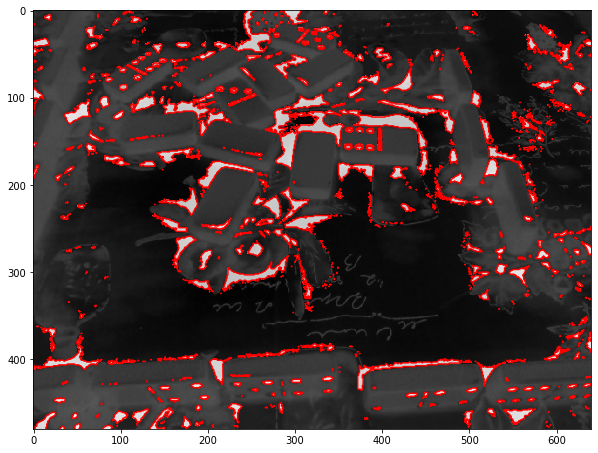

In [81]:
fig,ax = plt.subplots(figsize=(10,10))

contours = find_contours(im_local,0.45)

ax.imshow(im_local,cmap='gray')
for n, contour in enumerate(contours):
    ax.plot(contour[:,1],contour[:,0],color='r')

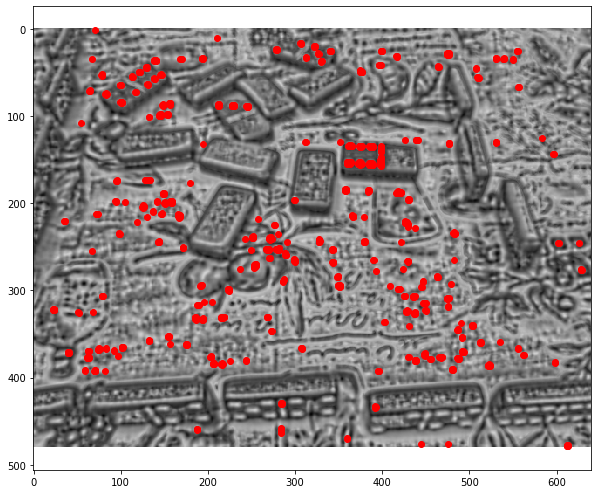

In [90]:
thresh = flt.threshold_otsu(test1)
locs = np.where(test1>thresh*1.5)
fig,ax = plt.subplots(figsize=(10,10))

ax.imshow(test1,cmap='gray')
ax.scatter(locs[1],locs[0],color='r')

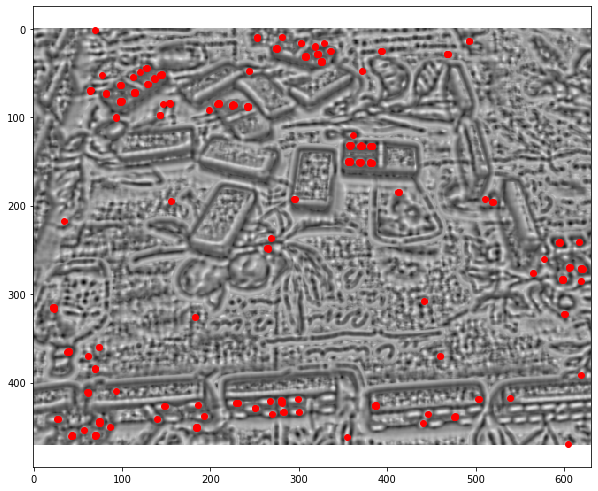

In [93]:
thresh = flt.threshold_otsu(result1)
locs = np.where(result1>thresh*1.7)
fig,ax = plt.subplots(figsize=(10,10))

ax.imshow(result1,cmap='gray')
ax.scatter(locs[1],locs[0],color='r')

In [103]:
from skimage.feature import blob_doh

In [128]:
thresh=flt.threshold_otsu(result1)
blobs = blob_doh(result1,threshold=0.2,min_sigma=0.01)



In [129]:
blobs

array([], shape=(0, 3), dtype=float64)

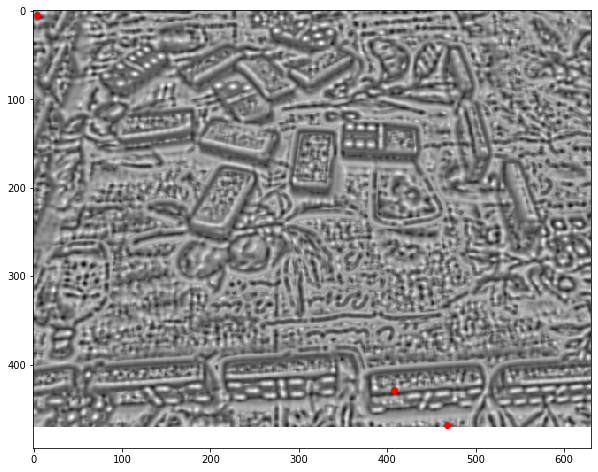

In [111]:
fig,ax = plt.subplots(figsize=(10,10))

ax.imshow(result1,cmap='gray')
ax.scatter(blobs[1,:],blobs[0,:],color='r')